In [ ]:
# Install deps
!pip -q install mediapipe==0.10.14 opencv-python-headless==4.10.0.84 tqdm==4.66.4
import sys, os, glob, json, random, math, time
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TF version:', tf.__version__)
print('Mediapipe version:', mp.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 40.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
preprocessing 0.

2025-09-07 01:05:19.639335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757207119.831486      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757207119.887319      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.18.0
Mediapipe version: 0.10.14


In [2]:
CFG = {
    # Add the dataset as a Kaggle input named exactly like this on the right panel → Add data → "grassknoted/asl-alphabet"
    'DATA_ROOTS': [
        '/kaggle/input/asl-alphabet',
        '/kaggle/input/asl-alphabet/asl_alphabet_train',
        '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
    ],
    # CSV cache file
    'CSV_PATH': '/kaggle/working/asl_landmarks.csv',
    # If None → use all images; to speed up, set e.g. 1000 per class
    'MAX_IMAGES_PER_CLASS': None,
    # Train config
    'VAL_SIZE': 0.15,
    'RANDOM_STATE': 42,
    'BATCH_SIZE': 256,
    'EPOCHS': 40,
    'LEARNING_RATE': 1e-3,
    # Model export
    'MODEL_PATH': '/kaggle/working/asl_mediapipe_mlp.h5'
}

CFG


{'DATA_ROOTS': ['/kaggle/input/asl-alphabet',
  '/kaggle/input/asl-alphabet/asl_alphabet_train',
  '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'],
 'CSV_PATH': '/kaggle/working/asl_landmarks.csv',
 'MAX_IMAGES_PER_CLASS': None,
 'VAL_SIZE': 0.15,
 'RANDOM_STATE': 42,
 'BATCH_SIZE': 256,
 'EPOCHS': 40,
 'LEARNING_RATE': 0.001,
 'MODEL_PATH': '/kaggle/working/asl_mediapipe_mlp.h5'}

In [3]:
def auto_find_class_dirs(data_roots):
    candidates = []
    for root in data_roots:
        if not os.path.exists(root):
            continue
        # If this root directly contains class subfolders (A, B, C, ...)
        subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        # Heuristic: contains many letter-named folders
        if len(subdirs) >= 10:
            candidates.extend(subdirs)
    # If user mounted the top-level, pick the deepest set containing images
    class_dirs = []
    for d in candidates:
        img_files = glob.glob(os.path.join(d, '*.jpg')) + glob.glob(os.path.join(d, '*.png'))
        if len(img_files) > 0:
            class_dirs.append(d)
    # Group by parent — prefer the parent with the most classes
    parents = {}
    for d in class_dirs:
        p = os.path.dirname(d)
        parents.setdefault(p, []).append(d)
    if not parents:
        raise FileNotFoundError('Could not find class directories. Make sure you added the Kaggle dataset input.')
    parent, dirs = sorted(parents.items(), key=lambda kv: len(kv[1]), reverse=True)[0]
    print(f"Using parent folder: {parent}")
    return sorted(dirs)

CLASS_DIRS = auto_find_class_dirs(CFG['DATA_ROOTS'])
CLASSES = [os.path.basename(d) for d in CLASS_DIRS]
print('Classes found (sample):', CLASSES[:10], '... total:', len(CLASSES))


Using parent folder: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
Classes found (sample): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ... total: 29


In [4]:
def extract_hand_landmark_vec(image_bgr, hands):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if not results.multi_hand_landmarks:
        return None, None
    # Choose the hand with max score
    best_idx, best_score = 0, -1
    for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
        score = results.multi_handedness[i].classification[0].score if results.multi_handedness else 0
        if score > best_score:
            best_idx, best_score = i, score
    hand_landmarks = results.multi_hand_landmarks[best_idx]
    handedness = results.multi_handedness[best_idx].classification[0].label if results.multi_handedness else 'Unknown'
    # Gather raw landmark coords
    pts = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=np.float32)  # (21,3)
    # Normalize: translate by wrist and scale by max pairwise distance for scale invariance
    wrist = pts[0].copy()
    pts -= wrist
    dists = np.linalg.norm(pts[None, :, :] - pts[:, None, :], axis=-1)
    scale = np.max(dists)
    if scale < 1e-6:
        scale = 1.0
    pts /= scale
    feat = pts.flatten()  # 63-dim
    return feat, handedness

def build_csv(csv_path, max_per_class=None):
    if os.path.exists(csv_path):
        print(f"CSV already exists at {csv_path}; skipping extraction.")
        return pd.read_csv(csv_path)
    rows = []
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True,
                         max_num_hands=2,
                         min_detection_confidence=0.5,
                         min_tracking_confidence=0.5) as hands:
        for class_dir in CLASS_DIRS:
            label = os.path.basename(class_dir)
            img_paths = sorted(glob.glob(os.path.join(class_dir, '*.jpg')) + glob.glob(os.path.join(class_dir, '*.png')))
            if max_per_class is not None:
                img_paths = img_paths[:max_per_class]
            pbar = tqdm(img_paths, desc=f"{label}", leave=False)
            for p in pbar:
                img = cv2.imread(p)
                if img is None:
                    continue
                feat, handed = extract_hand_landmark_vec(img, hands)
                if feat is None:
                    continue
                row = {'label': label, 'handedness': handed}
                for i, v in enumerate(feat):
                    row[f'f{i:02d}'] = float(v)
                rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} rows → {csv_path}")
    return df

df = build_csv(CFG['CSV_PATH'], CFG['MAX_IMAGES_PER_CLASS'])
df.head()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
A:   0%|          | 0/3000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
W0000 00:00:1757207132.128853     112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1757207132.165667     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Saved 63831 rows → /kaggle/working/asl_landmarks.csv


,label,handedness,f00,f01,f02,f03,f04,f05,f06,f07,...,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62
0,A,Left,0.0,0.0,0.0,0.255013,-0.179728,-0.080040,0.411013,-0.470947,...,-0.068931,-0.149020,-0.589960,-0.157814,-0.118062,-0.402817,-0.124725,-0.120593,-0.282902,-0.064965
1,A,Left,0.0,0.0,0.0,0.259495,-0.153247,-0.060678,0.418755,-0.457553,...,-0.084023,-0.116106,-0.553542,-0.164667,-0.086466,-0.357255,-0.139278,-0.091034,-0.235434,-0.091222
2,A,Left,0.0,0.0,0.0,0.209467,-0.160947,-0.091783,0.356155,-0.460957,...,-0.024192,-0.287416,-0.634243,-0.111358,-0.267033,-0.471697,-0.091532,-0.238321,-0.339349,-0.042784
3,A,Left,0.0,0.0,0.0,0.223916,-0.194541,-0.080841,0.352873,-0.487526,...,-0.095001,-0.208366,-0.579846,-0.208357,-0.154072,-0.395750,-0.180095,-0.144319,-0.268238,-0.120818
4,A,Left,0.0,0.0,0.0,0.223248,-0.176499,-0.079229,0.357216,-0.486654,...,-0.103010,-0.201985,-0.573615,-0.220350,-0.148045,-0.387330,-0.196110,-0.129040,-0.255759,-0.138961


In [5]:
# Prepare X/y
feature_cols = [c for c in df.columns if c.startswith('f')]
label_names = sorted(df['label'].unique().tolist())
label_to_id = {c:i for i, c in enumerate(label_names)}
id_to_label = {i:c for c, i in label_to_id.items()}

X = df[feature_cols].values.astype('float32')
y = df['label'].map(label_to_id).values.astype('int64')

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=CFG['VAL_SIZE'], random_state=CFG['RANDOM_STATE'], stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

num_classes = len(label_names)
input_dim = X_train.shape[1]
(input_dim, num_classes, label_names[:10])


(63, 29, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

In [6]:
def build_mlp(input_dim, num_classes, lr=CFG['LEARNING_RATE']):
    inputs = keras.Input(shape=(input_dim,), name='landmarks')
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='asl_mediapipe_mlp')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mlp(input_dim, num_classes)
model.summary()


I0000 00:00:1757210340.645377      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757210340.646062      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "asl_mediapipe_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ landmarks (InputLayer)          │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63)             │           252 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,809 (214.10 KB)

 Trainable params: 53,915 (210.61 KB)

 Non-trainable params: 894 (3.49 KB)

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(CFG['MODEL_PATH'], monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CFG['EPOCHS'],
    batch_size=CFG['BATCH_SIZE'],
    callbacks=callbacks,
    verbose=1
)

# Ensure a final save (in case checkpoint didn't trigger yet)
model.save(CFG['MODEL_PATH'])
print('Saved model to', CFG['MODEL_PATH'])


Epoch 1/40


I0000 00:00:1757210344.063354     130 service.cc:148] XLA service 0x788a64006360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757210344.063789     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757210344.063828     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757210344.404125     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


 64/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5940 - loss: 1.5925

I0000 00:00:1757210346.628459     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7840 - loss: 0.8478 - val_accuracy: 0.9693 - val_loss: 0.2864
Epoch 2/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9715 - loss: 0.1099 - val_accuracy: 0.9836 - val_loss: 0.0663
Epoch 3/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0749 - val_accuracy: 0.9857 - val_loss: 0.0513
Epoch 4/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0657 - val_accuracy: 0.9884 - val_loss: 0.0394
Epoch 5/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0542 - val_accuracy: 0.9899 - val_loss: 0.0370
Epoch 6/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9862 - loss: 0.0481 - val_accuracy: 0.9904 - val_loss: 0.0341
Epoch 7/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0475 - val_accuracy: 0.9899 - val_loss: 0.0364
Epoch 8/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0434 - val_accuracy: 0.9915 - val

Validation accuracy: 0.9926
['nothing']

Classification report:
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       329
           B       0.99      1.00      1.00       332
           C       1.00      1.00      1.00       299
           D       1.00      0.99      1.00       369
           E       1.00      1.00      1.00       347
           F       1.00      1.00      1.00       432
           G       1.00      1.00      1.00       366
           H       1.00      1.00      1.00       359
           I       0.99      0.99      0.99       358
           J       1.00      1.00      1.00       387
           K       1.00      0.99      0.99       405
           L       1.00      1.00      1.00       379
           M       0.94      0.98      0.96       239
           N       0.97      0.94      0.96       195
           O       1.00      0.99      1.00       341
           P       0.98      1.00      0.99       306
           Q     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

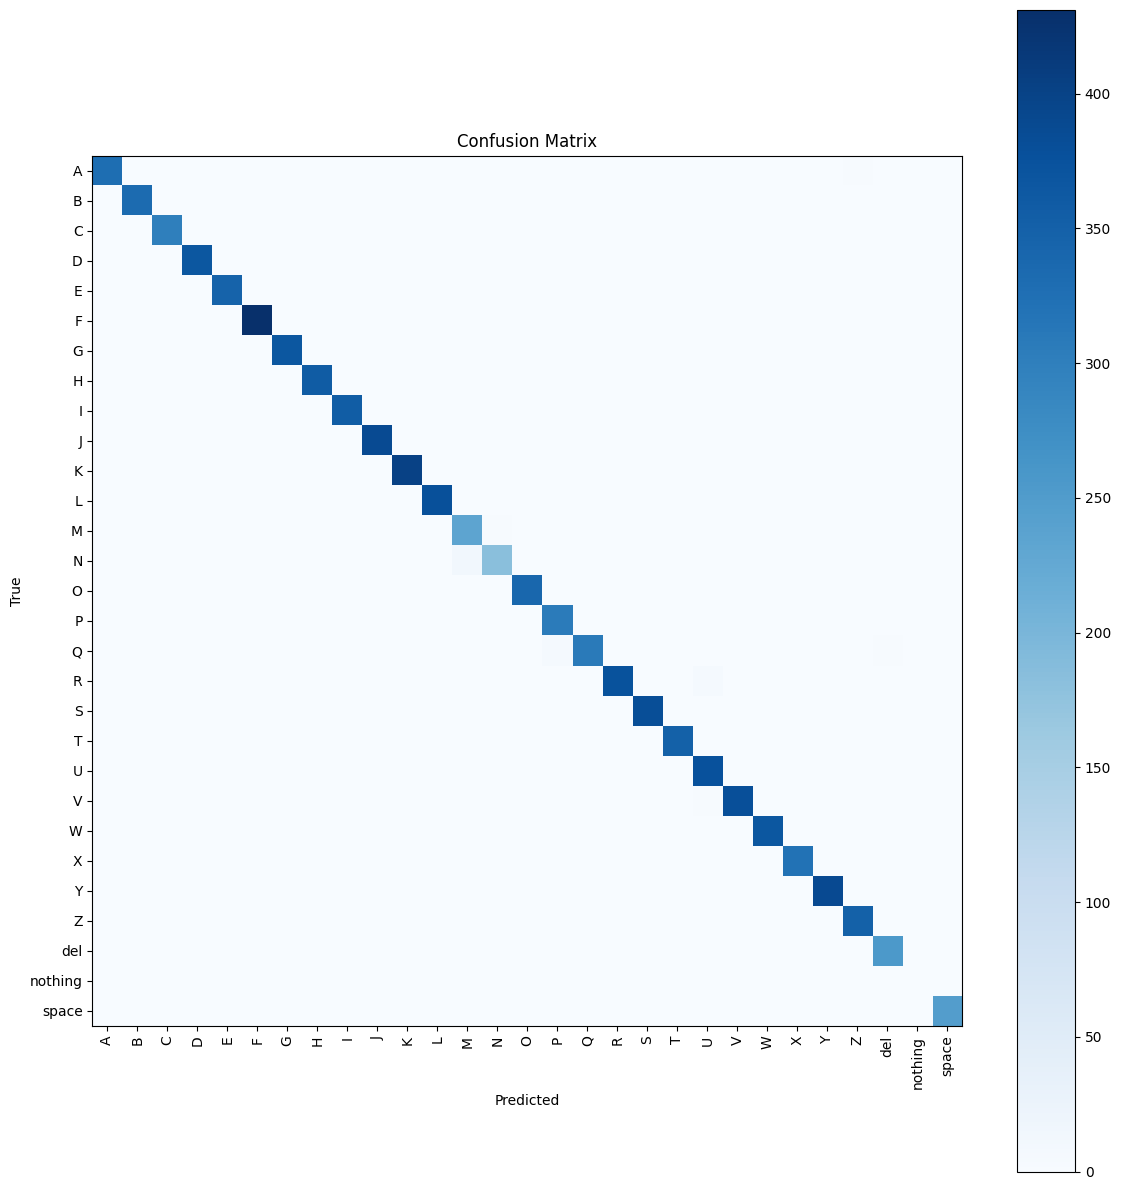

In [8]:
# Evaluate model predictions
val_probs = model.predict(X_val, verbose=0)
val_pred = np.argmax(val_probs, axis=1)
acc = accuracy_score(y_val, val_pred)
print(f'Validation accuracy: {acc:.4f}')

# Check for missing classes in validation set
missing_classes = set(range(num_classes)) - set(np.unique(y_val))
if missing_classes:
    print('Warning: Some classes are missing in validation set:')
    print([id_to_label[i] for i in missing_classes])

# Proper classification report with explicit labels
print('\nClassification report:')
print(classification_report(
    y_val, 
    val_pred, 
    labels=list(range(num_classes)), 
    target_names=label_names
))

# Confusion matrix visualization
cm = confusion_matrix(y_val, val_pred, labels=list(range(num_classes)))
fig = plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(num_classes), label_names, rotation=90)
plt.yticks(range(num_classes), label_names)
plt.colorbar()
plt.tight_layout()
plt.show()


In [9]:
def predict_image(path, hands, scaler, model, id_to_label):
    img = cv2.imread(path)
    if img is None:
        return None
    feat, handed = extract_hand_landmark_vec(img, hands)
    if feat is None:
        return None
    x = np.array(feat, dtype='float32').reshape(1, -1)
    x = scaler.transform(x)
    probs = model.predict(x, verbose=0)[0]
    top = int(np.argmax(probs))
    return id_to_label[top], float(probs[top])

mp_hands = mp.solutions.hands
sample_dirs = random.sample(CLASS_DIRS, min(3, len(CLASS_DIRS)))
with mp_hands.Hands(static_image_mode=True,
                     max_num_hands=2,
                     min_detection_confidence=0.5,
                     min_tracking_confidence=0.5) as hands:
    for d in sample_dirs:
        img_paths = glob.glob(os.path.join(d, '*.jpg')) + glob.glob(os.path.join(d, '*.png'))
        if not img_paths:
            continue
        p = random.choice(img_paths)
        pred = predict_image(p, hands, scaler, model, id_to_label)
        print(os.path.basename(d), '=>', pred, 'on', os.path.basename(p))


W0000 00:00:1757210364.934064     679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1757210364.963663     679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Z => None on Z2529.jpg
P => None on P2641.jpg
U => ('U', 0.9994946718215942) on U355.jpg


In [10]:
print('CSV at:', CFG['CSV_PATH'], os.path.exists(CFG['CSV_PATH']))
print('Model at:', CFG['MODEL_PATH'], os.path.exists(CFG['MODEL_PATH']))


CSV at: /kaggle/working/asl_landmarks.csv True
Model at: /kaggle/working/asl_mediapipe_mlp.h5 True


In [13]:
DO_TFLITE = False  # set True to export tflite
if DO_TFLITE:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    tfl_path = '/kaggle/working/asl_mediapipe_mlp.tflite'
    with open(tfl_path, 'wb') as f:
        f.write(tflite_model)
    print('Saved', tfl_path)


In [14]:
import joblib

# Example after training:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Assuming X_train is your training features

# Save the scaler to a file
joblib.dump(scaler, 'scaler.save')
print('Scaler saved successfully!')


Scaler saved successfully!
